In [1]:
"""
刘某历经千辛万苦，终于整利索的代码，附有详细中文注释
"""

'\n刘某历经千辛万苦，终于整利索的代码，附有详细中文注释\n'

In [2]:
# 调库
import pickle # 用来序列化的包
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer # 该类允许使用两种方法向量化一个文本语料库： 将每个文本转化为一个整数序列（每个整数都是词典中标记的索引）； 或者将其转化为一个向量，其中每个标记的系数可以是二进制值、词频、TF-IDF权重等。
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Embedding, Dense, TimeDistributed, Concatenate, BatchNormalization, MaxPooling1D
from keras.layers import Bidirectional, Activation, Dropout, GRU, Conv1D

from sklearn.model_selection import train_test_split, KFold
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.regularizers import l1, l2
import tensorflow as tf

import os

In [3]:
# 读数据,这两个数据都是做过onehot编码的
# cb6133         = np.load("../data/cb6133.npy")
cb6133filtered = np.load("../data/cullpdb+profile_6133_filtered.npy.gz")
cb513          = np.load("../data/cb513+profile_split1.npy.gz")

# 看一眼数据大小
# print(cb6133.shape)
print(cb6133filtered.shape) #(5534, 39900),39900=57*700
print(cb513.shape)
# cb6133filtered[0,-57:-1]

(5534, 39900)
(514, 39900)


In [4]:
# 部分超参数设置
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)  ##不建议0.8，因为可能有别的东西也用显存
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

maxlen_seq = r = 700 # protein residues padded to 700，统一设置成700的序列长度
f = 57  # number of features for each residue，onehot后的总特征数量=22+8+5+22
residue_list = list('ACEDGFIHKMLNQPSRTWVYX') + ['NoSeq'] # 长度是21+1
q8_list      = list('LBEGIHST') + ['NoSeq']
columns = ["id", "len", "input", "profiles", "expected"]
drop_out=0.4
num_classes = 9

In [14]:
# 函数定义
def get_data(arr, bounds=None): # 把预测得到的分段的 onehot编码 解码成我们想要的氨基酸序列
    
    if bounds is None: bounds = range(len(arr)) # 应该是蛋白质序列的条数
    
    data = [None for i in bounds] # 新建了一个长度和arr一样的空列表
    for i in bounds:
        seq, q8, profiles = '', '', []
        for j in range(r):
            jf = j*f # 1*57---->700*57
            
            # Residue convert from one-hot to decoded，应该是从onehot编码解码为氨基酸序列
            residue_onehot = arr[i,jf+0:jf+22] # 取了某一条氨基酸序列中的某个氨基酸的57各特征中的前22个特征的概率？
            residue = residue_list[np.argmax(residue_onehot)] # 这22个特征中概率最大的成为这个氨基酸的特征，此处为氨基酸的种类

            # Q8 one-hot encoded to decoded structure symbol，应该是从onehot解码为氨基酸二级结构
            residue_q8_onehot = arr[i,jf+22:jf+31] # 同上
            residue_q8 = q8_list[np.argmax(residue_q8_onehot)] # 同上

            if residue == 'NoSeq': break      # terminating sequence symbol，遇到编码为NoSeq，应该是意味着这串氨基酸序列结束了

            # 下面这仨应该就是蛋白质的一些其他特征，包括profile（亲戚关系？）啥的，可能还有什么像是溶剂可溶性？
            nc_terminals = arr[i,jf+31:jf+33] # nc_terminals = [0. 0.]
            sa = arr[i,jf+33:jf+35]           # sa = [0. 0.]
            profile = arr[i,jf+35:jf+57]      # profile features，这个就是PSSM亲戚特征
            
            
            
            seq += residue # concat residues into amino acid sequence，把氨基酸序列预测结果连接起来
            q8  += residue_q8 # concat secondary structure into secondary structure sequence， 把氨基酸二级结构预测结果连接起来
            profiles.append(profile) # 将亲戚信息保存起来，后续用来作为网络的输入的一部分
        
        data[i] = [str(i+1), len(seq), seq, np.array(profiles), q8] # 【蛋白质编号，蛋白质长度，蛋白质序列，蛋白质亲戚信息，蛋白质二级结构】
    
    return pd.DataFrame(data, columns=columns) # 输出成pandas的数据结构，二维的貌似？

# The custom accuracy metric used for this task，要自己定义一个正确率，不然keras默认的那个accuracy是包含那些700的长度后面补的NoSeq
def myaccuracy(y_true, y_pred):
    y = tf.argmax(y_true, axis =- 1) # 用最后一个维度进行封包，然后不同包之间进行比较，比较对应位置的大小
    y_ = tf.argmax(y_pred, axis =- 1)
    mask = tf.greater(y, 0) # y中比0大的赋值为true，比0小和等于0的赋值为false，这样子就把后面那些空的去掉了，只比对有值的内容的正确率
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx()) # floatx是默认的浮点数类型，tf.boolean_mask返回mask为true的y的对应位置的内容，equal返回布尔型的list，cast类型转换此处为1.和0

# Maps the sequence to a one-hot encoding
# 简单onehot解码
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i] # 字符串加法
        else:
            break
    return s

# 简单onehot编码
def seq2onehot(seq, n):
    out = np.zeros((len(seq), maxlen_seq, n)) # （氨基酸序列条数，700，22（onehot的维度））
    for i in range(len(seq)): # i是第几条氨基酸序列的序号
        for j in range(maxlen_seq): # j是第i条氨基酸序列的第几个氨基酸的序号，1---700
            out[i, j, seq[i, j]] = 1 # 懂了，seq[i,j]这个值是多少（x），我们就在第几(x)个位置填1，这个值只能有22种可能性
    return out

# ngrams第N个词的出现只与前面N-1个词相关，而与其它任何词都不相关，整句的概率就是各个词出现概率的乘积。这些概率可以通过直接从语料中统计N个词同时出现的次数得到。常用的是二元的Bi-Gram和三元的Tri-Gram
def seq2ngrams(seqs, n = 1): # 此处n=1，所以某一条氨基酸序列中每个氨基酸前后不相关，所以此时实际效果就像把序列每个氨基酸分开了
    return np.array([[seq[i : i + n] for i in range(len(seq))] for seq in seqs])

def decode_results(y_, reverse_decoder_index): # 根据字典进行onehot解码
    print("prediction: " + str(onehot_to_seq(y_, reverse_decoder_index).upper())) # .upper()小写字母转为大写字母
    return str(onehot_to_seq(y_, reverse_decoder_index).upper())

def run_test(_model, data1,  csv_name, npy_name):
    reverse_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()} # 把字典反向，用来解码，现在是1:'h'这样子
    reverse_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()} # 把字典反向用来编码
    
    # Get predictions using our model
    y_test_pred = _model.predict(data1) # 【我们自己onehot的氨基酸种类序列，embedding张成的64维的氨基酸种类序列，PSSM信息】

    decoded_y_pred = []
    for i in range(len(test_input_data)):
        res = decode_results(y_test_pred[i], reverse_decoder_index) # 应该是从onehot解码成二级结构序列
        decoded_y_pred.append(res)

    # Set Columns，设置输出的dataframe有哪些内容
    out_df = pd.DataFrame()
    out_df["id"] = test_df.id.values
    out_df["real"] = test_df.expected.values
    out_df["predict"] = decoded_y_pred

    # 输出一下测试集的预测正确率
    testaccseq=myaccuracy(test_target_data,y_test_pred)
    testacc=np.sum(testaccseq)/testaccseq.shape
    print('测试集的正确率：',testacc)
    # Save results，这里保存的是解码后的
    with open(csv_name, "w") as f:
        out_df.to_csv(f, index=False)

    np.save(npy_name, y_test_pred) # 这里保存的是没解码的

def CNN_BIGRU():
    # Inp is one-hot encoded version of inp_alt，就是这句英文的意思，需要在调用的时候被输入
    inp          = Input(shape=(maxlen_seq, n_words))
    inp_alt      = Input(shape=(maxlen_seq,))
    inp_profiles = Input(shape=(maxlen_seq, 22))

    # Concatenate embedded and unembedded input
    x_emb = Embedding(input_dim=n_words, output_dim=64, 
                      input_length=maxlen_seq)(inp_alt) # 将正整数（索引值）转换为固定尺寸的稠密向量。该层只能用作模型中的第一层。此处都变成64维的。目的是为了让网络的初始化更加合理，而不是像onehot那样子很稀疏，这样子网络能够更好地收敛。而且输入支持维度不同的list。
    # 网络结构1
    x = Concatenate(axis=-1)([inp, x_emb, inp_profiles]) # 这个地方将：【我们自己onehot的氨基酸种类序列，embedding张成的64维的氨基酸种类序列，PSSM信息】这仨连接在一起，都输入网络进行学习

    # 网络结构2：CNN部分，具体几乘几还不确定
    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)

    # 网络结构3：bidir-GRU部分
    x = Bidirectional(GRU(units = 256, return_sequences = True, recurrent_regularizer=l2(0.2)))(x) 
    # RNN 的双向封装器，对序列进行前向和后向计算。
    # units: 正整数，输出空间的维度。
    # return_sequences: 布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    # recurrent_regularizer: 运用到 recurrent_kernel 权值矩阵的正则化函数 (详见 regularizer)。lambda=0.2
    x = TimeDistributed(Dropout(0.5))(x) # 0.5的被丢弃了
    x = TimeDistributed(Dense(256, activation = "relu"))(x) # Dense：就是你常用的的全连接层。
    x = TimeDistributed(Dropout(0.5))(x)
    
    y = TimeDistributed(Dense(n_tags, activation = "softmax"))(x)
    
    model = Model([inp, inp_alt, inp_profiles], y) # 继承keras的Model类，设置输入为三个元素的list，输出为y
    
    return model # 定义网络

def CNN_model():
    m = Sequential()
    m.add(Conv1D(1024, 22, padding='same', activation='relu', input_shape=(maxlen_seq,22)))
    m.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    m.add(Dropout(drop_out))

    m.add(Conv1D(512, 22, padding='same', activation='relu'))
    m.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    m.add(Dropout(drop_out))

    m.add(Conv1D(256, 22, padding='same', activation='relu'))
    m.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    m.add(Dropout(drop_out))

    m.add(Conv1D(num_classes, 37, padding='same', activation='softmax'))

    return m


def train(X_train, y_train, X_val=None, y_val=None):
    """
    Main Training function with the following properties:
        Optimizer - Nadam
        Loss function - Categorical Crossentropy
        Batch Size - 128 (any more will exceed Collab GPU RAM)
        Epochs - 50
    """
    model = CNN_model() # 实例化自己定义的网络
    model.compile(
        optimizer="Nadam", # 某种优化算法
        loss = "categorical_crossentropy", # 交叉熵损失函数
        metrics = ["accuracy", myaccuracy]) # 衡量指标：700个的正确率（其中包括后面补的0），我自己写的正确率（序列多长算多长）
    
    
    #########################
    print(model.summary())
    
    
    if X_val is not None and y_val is not None:
        history = model.fit( X_train, y_train,
            batch_size = 128, epochs = 100,
            validation_data = (X_val, y_val)) # 用来评估损失，以及在每轮结束时的任何模型度量指标。模型将不会在这个数据上进行训练。
    else:
        history = model.fit( X_train, y_train,
            batch_size = 32, epochs = 100, verbose=1) # 一个 History 对象。其 History.history 属性是连续 epoch 训练损失和评估值，以及验证集损失和评估值的记录（如果适用）。

    return history, model



In [6]:
# 数据处理
'''
此处稍微记录一下,免得再看到处翻

通用：
tokenizer_encoder：氨基酸种类词典
tokenizer_decoder：氨基酸二级结构词典
n_words：氨基酸种类词典词种类数，22
n_tags：氨基酸二级结构词典词种类数，9

训练：
train_df：训练数据的dataframe，其中包括【序号，序列长度，氨基酸种类序列，PSSM信息，二级结构种类序列】
train_input_seqs：氨基酸种类序列
train_target_seqs：二级结构种类序列
train_input_grams：氨基酸种类序列切分开
tokenizer_encoder.texts_to_sequences(train_input_grams)：氨基酸种类序列切分开后转成数字序列，其中数字种类总共有22种
train_input_data_alt：氨基酸种类序列，切分开，后转成数字序列，后第二个维度扩展到700，也就是都认为长度是700
train_input_data：氨基酸种类序列，切分开，后转成数字序列，后第二个维度扩展到700，onehot
tokenizer_decoder.texts_to_sequences(train_target_seqs)：二级结构种类序列转成数字序列，数字种类共9种
sequence.pad_sequences(train_target_data,maxlen = maxlen_seq, padding='post')：二级结构种类序列转成数字序列后第二个维度扩展到700
train_target_seqs：二级结构种类序列转成数字序列后第二个维度扩展到700后进行onehot并且再复制一份反的用来做交叉熵
train_profiles：未处理的onehot的PSSM信息
train_profiles_np：补长到700的onehot的PSSM信息

测试：
test_df：同
test_input_seqs：
test_input_grams：
tokenizer_encoder.texts_to_sequences(test_input_grams)：种类
test_input_data_alt：数字序列
test_input_data：
tokenizer_decoder.texts_to_sequences(test_df.expected.values)：二级结构
sequence.pad_sequences(test_target_data, maxlen = maxlen_seq, padding='post')：数字序列
test_target_data：将测试集的氨基酸二级结构序列进行onehot
test_profiles
test_profiles_np

'''


# Train-test Specification，得到了漂亮的数据结构
train_df = get_data(cb6133filtered) # 用来训练
test_df  = get_data(cb513) # 用来测试

# Computes and returns the n-grams of a particular sequence, defaults to trigrams
# Loading and converting the inputs to trigrams，加载并且将其转置，此处转置没啥用，但是如果上面n大于1，就有用了
train_input_seqs, train_target_seqs = \
    train_df[['input', 'expected']][(train_df.len.astype(int) <= maxlen_seq)].values.T # astpye(int)将int64转为int32，.values提取值（不包含序号），.T表示转置
train_input_grams = seq2ngrams(train_input_seqs)

# Same for test，同上
test_input_seqs = test_df['input'].values.T
test_input_grams = seq2ngrams(test_input_seqs)

# Initializing and defining the tokenizer encoders and decoders based on the train set
# Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类。Tokenizer实际上只是生成了一个字典，并且统计了词频等信息，并没有把文本转成需要的向量表示。
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(train_input_grams) # 生成氨基酸种类词典
tokenizer_decoder = Tokenizer(char_level = True) # char_level：如果为True，每个字符将被视为一个标记
tokenizer_decoder.fit_on_texts(train_target_seqs) # 生成氨基酸二级结构词典

# Computing the number of words and number of tags for the keras model，统计一下两个字典的数量，keras运行时需要这个参数
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1

# Using the tokenizer to encode and decode the sequences for use in training，用字典来将字符转换为数字
# Inputs
train_input_data = tokenizer_encoder.texts_to_sequences(train_input_grams) # 将氨基酸序列通过字典,变成数字序列
train_input_data = sequence.pad_sequences(train_input_data,
                                          maxlen = maxlen_seq, padding='post') # 把不等长的list变成等长,默认填充是０,padding='post'是后填充即后面是0

# Targets
train_target_data = tokenizer_decoder.texts_to_sequences(train_target_seqs) # 将氨基酸二级结构序列通过字典，变成数字序列
train_target_data = sequence.pad_sequences(train_target_data,
                                           maxlen = maxlen_seq, padding='post') # 同上
train_target_data = to_categorical(train_target_data) # to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示，此处用途为简易onehot

# Use the same tokenizer defined on train for tokenization of test，对测试集进行同上操作
test_input_data = tokenizer_encoder.texts_to_sequences(test_input_grams)
test_input_data = sequence.pad_sequences(test_input_data,
                                         maxlen = maxlen_seq, padding='post')
test_target_data = tokenizer_decoder.texts_to_sequences(test_df.expected.values) # 将测试集的氨基酸二级结构序列通过字典，变成数字序列
test_target_data = sequence.pad_sequences(test_target_data,
                                           maxlen = maxlen_seq, padding='post') # 同上
test_target_data = seq2onehot(test_target_data,n_tags) # 将测试集的氨基酸二级结构序列进行onehot


train_input_data_alt = train_input_data # 做了个备份
train_input_data = seq2onehot(train_input_data, n_words) # 对训练集的data进行onehot
train_profiles = train_df.profiles.values # 取出PSSM信息

test_input_data_alt = test_input_data # 同上
test_input_data = seq2onehot(test_input_data, n_words)
test_profiles = test_df.profiles.values

# 下面这一段的作用是把5534条不同长度的氨基酸序列中每个氨基酸的PSSM信息，存成一样700长的氨基酸序列中每个氨基酸的PSSM信息，存成三维的np数组，补充出来的那些氨基酸的PSSM信息都是0
train_profiles_np = np.zeros((len(train_profiles), maxlen_seq, 22))
for i, profile in enumerate(train_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            train_profiles_np[i, j, k] = profile[j, k]

# 同上
test_profiles_np = np.zeros((len(test_profiles), maxlen_seq, 22))
for i, profile in enumerate(test_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            test_profiles_np[i, j, k] = profile[j, k]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 700, 1024)         496640    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 700, 1024)         0         
_________________________________________________________________
dropout (Dropout)            (None, 700, 1024)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 700, 512)          11534848  
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 700, 512)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 700, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 700, 256)          2

173/173 [==============================] - 53s 304ms/step - loss: 0.1400 - accuracy: 0.9464 - myaccuracy: 0.8244
Epoch 51/100
173/173 [==============================] - 51s 292ms/step - loss: 0.1382 - accuracy: 0.9470 - myaccuracy: 0.8264
Epoch 52/100
173/173 [==============================] - 51s 297ms/step - loss: 0.1371 - accuracy: 0.9475 - myaccuracy: 0.8283
Epoch 53/100
173/173 [==============================] - 53s 304ms/step - loss: 0.1358 - accuracy: 0.9479 - myaccuracy: 0.8294
Epoch 54/100
173/173 [==============================] - 54s 313ms/step - loss: 0.1350 - accuracy: 0.9484 - myaccuracy: 0.8310
Epoch 55/100
173/173 [==============================] - 54s 313ms/step - loss: 0.1333 - accuracy: 0.9490 - myaccuracy: 0.8330
Epoch 56/100
173/173 [==============================] - 54s 313ms/step - loss: 0.1329 - accuracy: 0.9492 - myaccuracy: 0.8337
Epoch 57/100
173/173 [==============================] - 54s 313ms/step - loss: 0.1311 - accuracy: 0.9497 - myaccuracy: 0.8354
Epoch

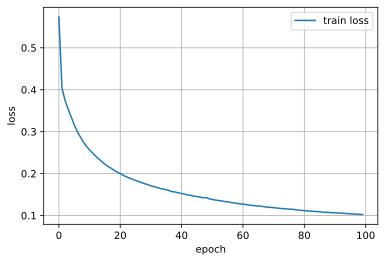

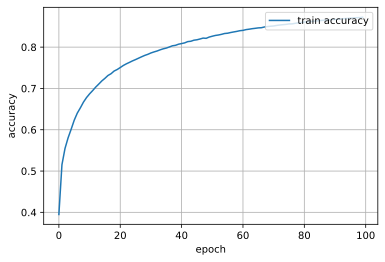

In [7]:
# 模型训练以及保存信息
# 打包一下训练用的数据（data和label）
X_train = train_input_data
y_train = train_target_data

history, model = train(X_train, y_train) # 模型训练，并且输出训练历史，有可以设置的参数

# 画图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# 画loss图
plt.plot(history.history['loss'],label='train loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.savefig('train_loss.png', dpi=500, bbox_inches='tight')
plt.show()
# 画正确率图
plt.plot(history.history['myaccuracy'],label='train accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc="upper right")
plt.savefig('train_accuracy.png', dpi=500, bbox_inches='tight')
plt.show()

# Save the model as a JSON format，把模型结构和参数权重保存下来
model.save_weights("cb513_weights_1.h5")
with open("model_1.json", "w") as json_file:
    json_file.write(model.to_json())

# Save training history for parsing，把训练过程保存下来
with open("history_1.pkl", "wb") as hist_file:
    pickle.dump(history.history, hist_file)
    
    
# model.load_weights("cb513_weights_1.h5")
# with open("history_1.pkl",'rb') as f:
#     data = pickle.load(f)

In [15]:
# 测试预测效果
# Predict on test dataset and save the output
run_test(model,
    test_input_data[:],csv_name="cb513_test_1.csv",npy_name= "cb513_test_prob_1.npy") # 保存的是解码后的和没解码的

prediction: LLLLEEEEEEEHHTHHHHHHHHHHHHLEEEEEEEEEEETTSLEEEEEEEEEEEEETTEEEEHHHTTL
prediction: LLLEEELLSSLEEEEEELHHHHHHHHHTSLLEEEEELLLLLLLLHHHHHHHHHHHTLLLTLEEEELSELLTTSSLLLLHHHHHHHHL
prediction: LLLLLLLLLLGGGTSEELLTLLEELLHHHHHHHHHHHLLLLLLEEEEEELLLLSHHHHHHHHHHHTTTLHHHTTLHTLLLLLEEEEHHHHHHTTLLHHHELHHHHHHHHHHHHHHHHHHTTLLLLLLLHHHHHHHHHHTTLLEEEELHHHHHHSLHHHHHHHHHHHGGTTTLLLLLLLLLEEEGTTTLHHHHHHHHTTLLEEEEELLHHHHHHHHHTTHHTHHHHHHHHHHHTLEEEELGGLLLHHHHHHHHHLLLLLLLLTTLLEEEELLTLLLLTTLSLLLLLLLLLGGGTTTHHHHHHHHHHHHHHHHHTLTTLEEEEEEELLTLLEEELLTTSSLLSSSLHHHHHHHHHHHHHHHTLEEEEEELSLGGGGLSSSTTSSGGTLEEEEELTTSLEEEEELLLLGGGHHHHHHHHHHHHHSLTTTTTEELLSHHHHHHHHHHHHTTLL
prediction: LLLEEEELLSLLLTTLEEEEEEELLTLEEEEEELLLLBELLTLLLLLLEEEEEETTSTEEEEEEEEELLTTLLTTLLLLLEEEEEEESSLLLLTTTTLEHHHHHHHLL
prediction: LLLLLLLLEEEEEELSSLLLLGGHHHHHHTTLLLLLLLLHHHHHHHHTTLLLTTHHHHHHHHHHHHHHHHTHHHHHHHHHHHHHHHHHHTTLEEEEEEEELHEEEEEELLLLLLTTTSSLLLHHHHHHHHHHHTTHHHHHTTEEHHHHHHHHTSLLHHHHHHHHHHHHHTLSLEEEEEETTSSEEEELLLHHHHHHHHHHHHHTTLEEEEEELLLLLHHHHHHHH

prediction: LLLLLLEEEEELLLLLHHHHHHHHHHHLLTTLHHHHHHHHHHHHHHHHHHHHHHHHHTLLLLLLTTLLLLHHEEEEEEELLLHHHHHHHHHHHHHHHHSLLLEETTLLHEELLHHHHHHHHHHHHTTLLLHHHHHHHHHHHHLLHEEELTLLLLHHHHHHHHHHHHHHHLLLLHHHHHHHGGGGTSSLLLLLHHHHHHHHTLLLEEEEEEELHHHHHHHHHHTTL
prediction: LLLLLLHHHHHHHTSSLLLHHHHHHHHHHHTTLEEEELTTSLEEEETTEEEEEEEEEEEETTEEEEEEHHHHHHHLSSLLLL
prediction: LLLLLLLLSSSLLLHHHHHHHHHHHHHHHTLLLTEEEEEEEELLLTLHHHHHHHHSLLLSSLLLLLEEEEELHHHHHHHHHHHHHTLEEEEEEELLLLL
prediction: LLLLLLHEEHHEEHSLHHHHHHHHHHTTLLLTEEEEELLSLEEEELGGGGLEEEEEEEEEEEEEEELLSSLLLEEEEEEEEEEETTTTEEEEEESSLLLLLLLLLLLLTTSLLLL
prediction: LLSLLLEEELTTSLEEEEEEEELLLTSSEEEEEEEEETLLEEEEEEEETTTEEEEEEEEEETTEEEEEELLTTSLHHHHHHHHHTTTLEEEELLLLLLLLLLTLLHHHHHHHHHHHTSLLLLLHHHHHHHHHHLLTTLLLEETLLTTLLHHHHHHHHHHHHHHLLSHEEHHHHHTTTEEEEETTLLHHHHHHHHHHHHELLLLLLLLLTTEEEEETTEEEESSSEEEEEEEEEELTSSLLEEEEEEGGLLTTTTSSLLLSLLLGGLLLLLHHHHHHHHHLTTLEEEELLTTSLLLLLLLEEEEEETTTSSSEEEEEEEEELTTLEEEEEEEETTTEEEEEELLTTLLLLSLLLTTSLSLEEEEELLLLLLLLLLTTEEEEEEEEEEEEELGGGGSTTLLLHEHHHHHHHHHTTTS

prediction: LLLHHHTSSTSEEEEEHHHHHLTLLLLLLLTTLLLLEEEEEEEETSLLEEEEEEEEEEEEEEEEEELLHTTTLLLTHHHHEEHLSSLLLHHHHHHHHHHHHEEEEEEELTTEEEEEEEELLSSEEEEEEEEEEEELLLTTSLLLLEEEEHHHHHHLLLEEEEEELLGGGLLEEEETTTEEEEEEEELLLLLLHHHHEEEEEEEEEEEEEEEEEEETEEEEEEEEEEEEEEHHHHEEEEELLGGGLLLLLTTLLLLLLLLLHHHHHLTTTLLLL
prediction: LLLLLLLLTTSEELLLTTSSLLTTSTTLLLLLLLLLLHEHHHHHEEELLEEELLGGLLLEEEEEEEEEEEELLSTTLEEEEEEEEEEEEEEEEEESTTEEEEEEEELTSLEEEEEEELLTTLLLEEEEEEELLTTTLLLLBHHHHHLLEEEEEEEEEEEEEEEELLESEEEEEEEELTTLLLHHHHHHHHLLLLLSLLLLLHHHHHHHHHHHHLLHHEEHHHHHHHHEEEEEELLL
prediction: LLLLLTTLLLLHHHHEELLLGGGHHHHHHHHHHTTLLLLL
prediction: LLEEEEEETTEEELTTTLLLSSLLLTTLLGGGLLTTEEELTTSLLHHHHHHHHL
prediction: LHHHHHHHHHHHHHHHHHHHHEEEELSTTTLLEEEEEEELLLLHHHHHHHHHHSSLLTTSLHHHHHHHHHHHHHHHHHHHHHTLLTTHEEEHHHHHHHGGGGGLLLHHHHHHHHHHHHHHHHHHLLTTTHHHHHHHHHHHHHHHL
prediction: LLLLLLLHHSLTSSEEEETTEEEEEELLLLSLLLLLLLELLLLEETTELLL
prediction: LLHHHHHHHHTEEELSSLHHHHHHHHHTTLEEEEEESLLLLTTTHHHHHHHHHHHHHHHHHTLLLEEEEEEEEEEELLTTTLLHHHHHHHHHHHHHHHHHHHHHHHHHHHH